In [231]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.naive_bayes import GaussianNB
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, accuracy_score
from IPython.display import clear_output
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
import time
from sklearn.neural_network import MLPClassifier


## Load the dataset

In [11]:
#load trees data
trees = pd.read_csv('county_tree_temp_dwp_prcp_KT_NS10.csv')
trees = trees.sort_values(['state_code','county_code','species','year'])
trees = trees.reset_index(drop = True)

In [71]:
trees.state_code.unique()

array([ 1,  5,  9, 10, 12, 13, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
       28, 29, 31, 33, 34, 36, 37, 38, 39, 40, 42, 44, 45, 46, 47, 48, 50,
       51, 54, 55])

## Prepare and clean dataset to be classified

In [19]:
spe = ['loblolly pine','sweetgum','red maple','slash pine','yellow-poplar',
      'balsam fir','sugar maple','quaking aspen','northern white-cedar','paper birch']

In [14]:
#clean data
trees = trees.drop(trees.loc[(trees.volume == 0) | (trees.height == 0)].index)

le = LabelEncoder()
trees['speciesID'] = le.fit_transform(trees.species)
trees['volume'] = trees['volume'] / trees['number_trees']
trees['Biomass'] = trees['Biomass'] / trees['number_trees']
trees['height'] = trees['height'] / trees['number_trees']
trees['diameter'] = trees['diameter'] / trees['number_trees']
trees['Density'] = trees['Biomass']/trees['volume']
trees['logMass'] = np.log(trees['Biomass'])
trees['logvolume'] = np.log(trees['volume'])
trees['logdensity'] = np.log(trees['Density'])
trees = trees.drop(trees.loc[trees.Density > 100].index)

species = trees.species.unique()

LabelEncoder()

## Classification using Bayes classifier

In [16]:
gnb = GaussianNB()
scaler = StandardScaler()


In [17]:
features = ['latitude','longitude','Density',
            'mean_temp','height','logdensity',
            'Biomass','diameter','mean_prcp',
            'mean_dwp','volume','logMass',
            'logvolume']

In [20]:
trees10 = trees.loc[trees.species.isin(spe)].copy() #top 10 trees
train,test = train_test_split(trees10,test_size=.1,shuffle=True,stratify = trees10.speciesID,random_state = 42)

### How do features change the answer?

In [96]:
runs = [4,6,8,9,13] #setup loop ranges for features
t0 = time.perf_counter()
y = train.speciesID
score = np.zeros((5,3))
for i,r in enumerate(runs):
    clear_output()
    print(f'Now working on {i}')
    f = features[:r]
    X = train[f].copy()
    score[i,:] = cross_val_score(gnb, X, y, cv=3, n_jobs = -1)
clear_output()
t1 = time.perf_counter()
print(f'Runtime: {t1-t0} seconds')
score.mean(axis = 1)

Runtime: 4.146246199001325 seconds


array([0.4401003 , 0.52989053, 0.54247689, 0.54154302, 0.49168601])

Seems that 8 features provides the best score

In [35]:
features[:8]

['latitude',
 'longitude',
 'Density',
 'mean_temp',
 'height',
 'logdensity',
 'Biomass',
 'diameter']

Text(0.5, 1.0, 'Gaussian Naive Bayes')

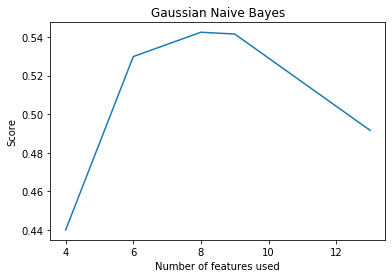

In [34]:
plt.plot(runs, score.mean(axis = 1))
plt.xlabel("Number of features used")
plt.ylabel("Score")
plt.title("Gaussian Naive Bayes")

What happens if a scaler is applied?

In [49]:
gnb = GaussianNB()
print("without scaler\n")
t0 = time.perf_counter()
y = train.speciesID
f = features[:8]
X = train[f].copy()
score = cross_val_score(gnb, X, y, cv=3, n_jobs = -1)

t1 = time.perf_counter()
print(f'Runtime:%0.4f seconds'%float(t1-t0))
print("Avg score is %0.5f"%score.mean())

print("with scaler\n")

t0 = time.perf_counter()
y = train.speciesID
f = features[:8]
X = train[f].copy()
X = scaler.fit_transform(X)
score = cross_val_score(gnb, X, y, cv=3, n_jobs = -1)

t1 = time.perf_counter()
print(f'Runtime:%0.4f seconds'%float(t1-t0))
print("Avg score is %0.5f"%score.mean())

without scaler

Runtime:0.2213 seconds
Avg score is 0.54248
with scaler

Runtime:0.2432 seconds
Avg score is 0.54262


## Score for different species

In [88]:
scaler = StandardScaler()
gnb = GaussianNB()
pipe = Pipeline([('scaler',scaler),('GausNB',gnb)])

In [89]:
trees10 = trees.loc[trees.species.isin(spe)].copy() #top 10 trees
train,test = train_test_split(trees10,test_size=.1,shuffle=True,stratify = trees10.speciesID,random_state = 42)

In [90]:
t0 = time.perf_counter()
y = train.speciesID
X = train[features[:8]].copy()
pred = cross_val_predict(pipe,X,y, cv=5, n_jobs = -1)
t1 = time.perf_counter()
print(f'Runtime: {t1-t0} seconds')

Runtime: 3.2365364430006593 seconds


In [91]:
pred_df = pd.DataFrame({'speciesID':y,'pred':pred,'correct': y == pred})
pred_df = pred_df.reset_index(drop = True)

precision = precision_score(y,pred, average = None)
recall = recall_score(y,pred, average = None)
matrix = confusion_matrix(y, pred)
accuracy = matrix.diagonal()/matrix.sum(axis=1)
speID = le.transform(spe)
orderedspecies = le.inverse_transform(np.sort(speID))
final = pd.DataFrame({'accuracy':accuracy,
                      'recall':recall,
                      'precision':precision},
                     index = orderedspecies)
final.loc['Total'] = [accuracy_score(y,pred),
                      recall_score(y,pred, average = 'macro'),
                      precision_score(y,pred, average = 'macro')]
final

,accuracy,recall,precision
balsam fir,0.871444,0.871444,0.622741
loblolly pine,0.658140,0.658140,0.476833
northern white-cedar,0.797167,0.797167,0.719349
paper birch,0.653320,0.653320,0.351366
quaking aspen,0.614997,0.614997,0.753159
red maple,0.401813,0.401813,0.527602
slash pine,0.567533,0.567533,0.506079
sugar maple,0.688291,0.688291,0.837204
sweetgum,0.436688,0.436688,0.372324
yellow-poplar,0.491636,0.491636,0.605402


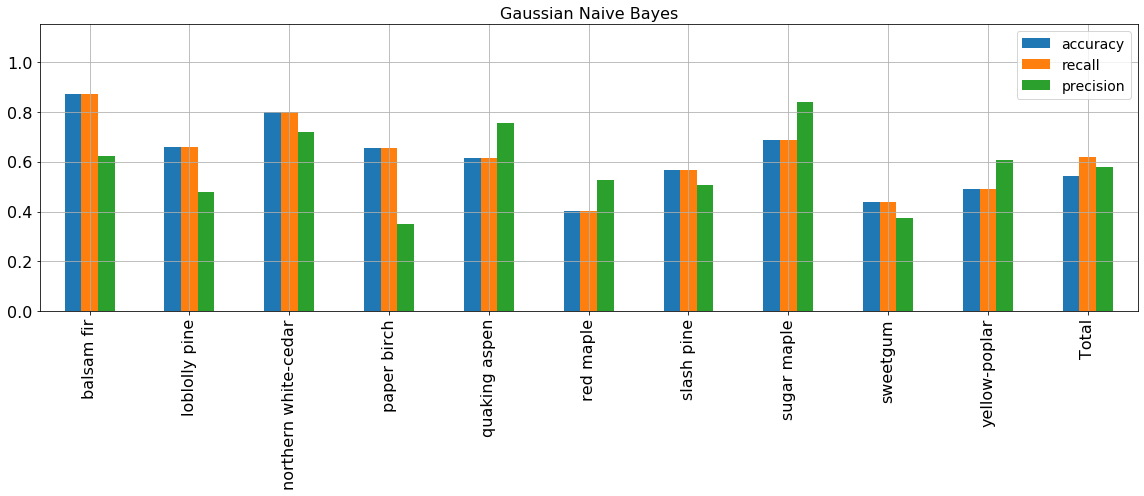

In [94]:
final.plot.bar(fontsize = 16,figsize = (16,7),legend = False)
plt.ylim((0,1.15))
plt.xlabel('',fontsize = 16)
plt.title('Gaussian Naive Bayes',fontsize = 16)
plt.legend(loc = 1,fontsize = 14)
plt.grid()
plt.tight_layout()
plt.savefig("NBGauss_score.png")

## Make and beautify Kent's plots

### Lat vs Lon for species

Import needed libs

In [195]:
import shapefile as shp
shp_path = "./cb_2018_us_state_20m/cb_2018_us_state_20m.shp"
import geopandas as gpd
import descartes

Load downloaded shape file and plot map + species plot

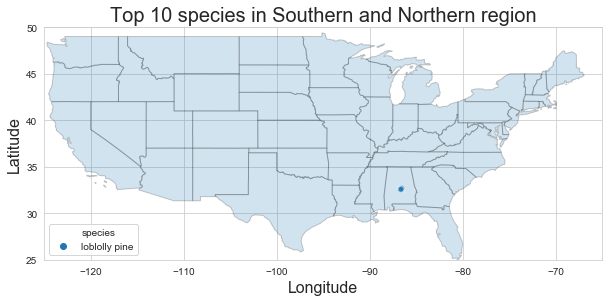

In [212]:
map_df = gpd.read_file(shp_path)
ax = map_df.plot(figsize=(10, 10), alpha=0.2, edgecolor='k')

xf = 'longitude'
yf = 'latitude'
# plt.figure(figsize=(10,8))
sns.scatterplot(data=trees.loc[trees.species.isin(spe)].head(10),x=xf,y=yf,hue="species", alpha=0.5)
#sns.scatterplot(data=trees.loc[trees.species.isin(species[::3])],x=xf,y=yf,hue="species")
plt.title("Top 10 species in Southern and Northern region",fontsize=20)
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
ax.set_ylim(25,50)
ax.set_xlim(-125,-65)
ax.legend(loc="lower left")
# plt.grid()
# plt.tight_layout()
# plt.savefig("/Users/neutrino/Downloads/SouthAndNorthern_region_trees_map.png", dpi = 200)

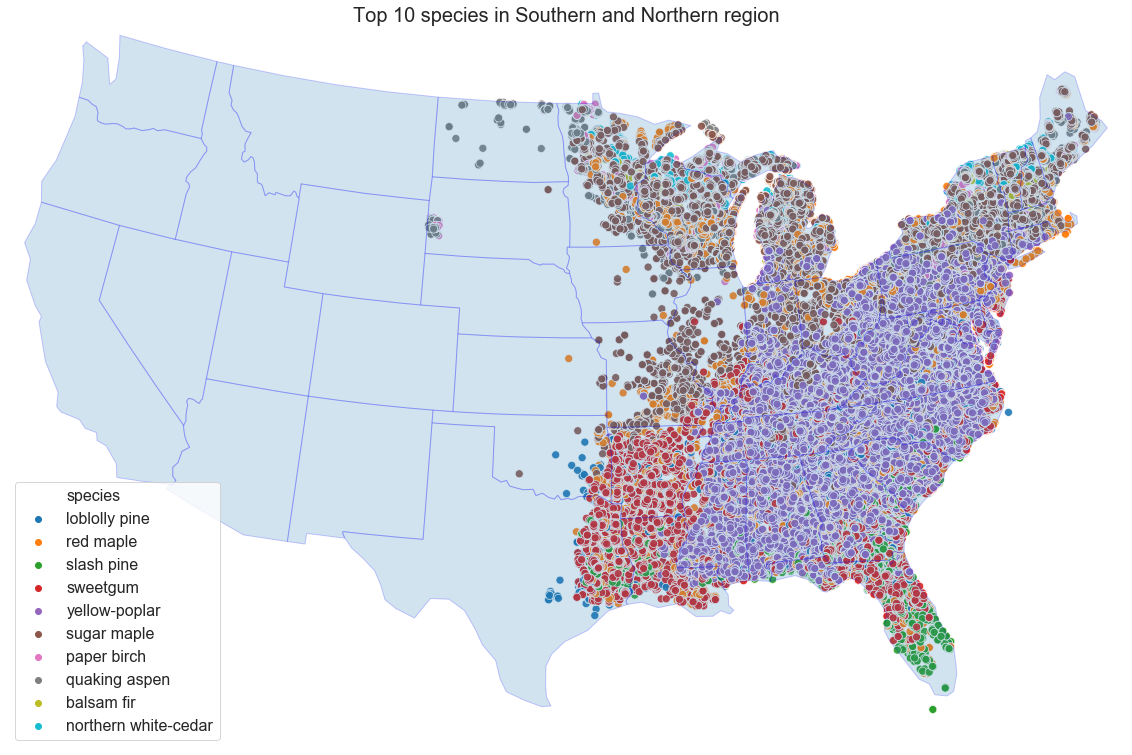

In [230]:
#for map plotting
import shapely
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

shapename = 'admin_1_states_provinces_lakes_shp'
states_shp = shpreader.natural_earth(resolution='110m',category='cultural', name=shapename)

xf = 'longitude'
yf = 'latitude'
fig = plt.figure(figsize = (16,10))
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal())
ax.set_extent([-119, -74, 22, 50], ccrs.Geodetic())
ax.add_geometries(shpreader.Reader(states_shp).geometries(), ccrs.PlateCarree(),alpha = 0.2, edgecolor='b')
sns.scatterplot(data=trees.loc[trees.species.isin(spe)],x=xf,y=yf,hue="species", 
                alpha=0.9,ax = ax,transform=ccrs.PlateCarree(),s = 65)
ax.legend(loc = 3,fontsize = 16)
ax.outline_patch.set_visible(False)
ax.set_title("Top 10 species in Southern and Northern region",fontsize=20)
# plt.tight_layout()
# plt.show()
plt.savefig("Top10_map.png", dpi=200)

### Tree density

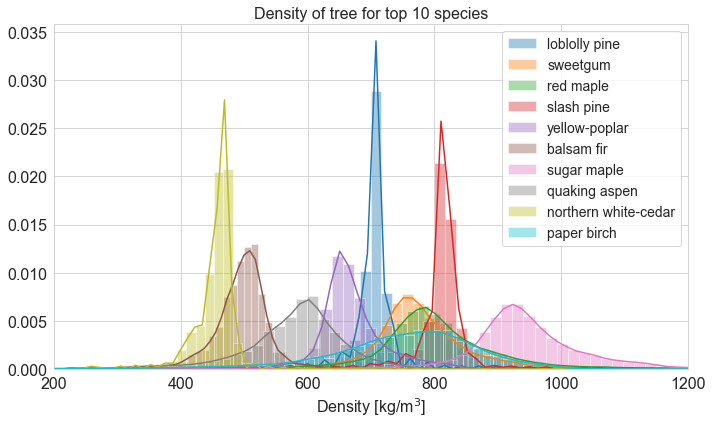

In [235]:
plt.figure(figsize=(10,6))
for i,s in enumerate(spe):
    sns.distplot(trees.loc[(trees.species == s) & (trees.Density < 50)]['Density']*35.315
,
                 bins = 100,label = s, norm_hist=True)
plt.legend(fontsize = 10)
plt.xlabel('Density [kg/m$^3$]',fontsize = 16)
plt.xlim((200,1200))
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 14)
plt.title('Density of tree for top 10 species',fontsize = 16)
plt.tight_layout()
plt.savefig("Top10_density.png", dpi=200)

## Temperature

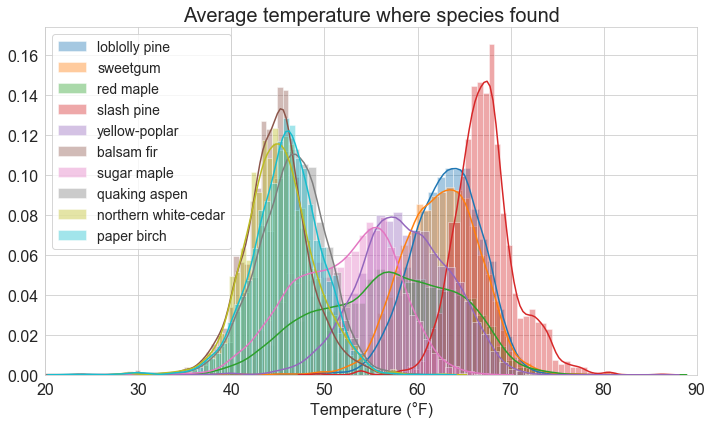

In [236]:
plt.figure(figsize=(10,6))
for i,s in enumerate(spe):
    sns.distplot(trees.loc[(trees.species == s) & (trees.Density < 50)]['mean_temp'],
                 bins = 60,label = s)
plt.legend(fontsize = 12)
plt.xlabel(u'Temperature (\N{DEGREE SIGN}F)',fontsize = 16)
plt.title('Average temperature where species found',fontsize = 20)
plt.xlim((20,90))
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 14)
plt.tight_layout()
plt.savefig("temp_top10Species.png", dpi = 200)